In [34]:
import json
import pandas as pd
import numpy as np
import re
import time
import requests
import os
from bs4 import BeautifulSoup

In [12]:
# written by Vincent
def getUrls(filename):
    '''
    Takes in a json file name (including the path) produced from a Diffbot crawl of `realtor.com` using image API json file.
    Returns a Series with all the unique realtor urls.
    '''
    f = open(filename)
    data = json.load(f)
    df = pd.json_normalize(data)
    urls = pd.Series(df['anchorUrl'].append(df['pageUrl']).unique())
    urls = urls[urls.notna() & urls.str.contains('https://www.realtor.com/realestateandhomes-detail/')]
    return urls

In [13]:
# written by Samantha Tang
def extract_images(url):
    
    '''
    Input: Takes in a home url address
    Output: Returns list of urls for photo gallery
    '''
    
    headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) \
               AppleWebKit/601.3.11 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9','Accept-Encoding': 'identity'}

    page = requests.get(URL, headers=headers)
    soup = BeautifulSoup(page.content, 'html.parser')
    html_filtered = soup.find_all('div', attrs={'class': 'background-item'}) 

    image_urls = []
    for e in html_filtered: 
        image_urls += re.findall("(http.*\.jpg|\.png|\.JPG|\.PNG)", str(e))
        
    return image_urls

In [31]:
# written by Parker Nelson
def get_content(urls):
    ## Given a singular url or list of urls, outputs soup objects
    ## This is to prevent a bunch of repeated reqests to Realtor.com
    
    list_of_soups = []
    
    for url in urls:
        
        time.sleep(np.random.uniform(3, 7)) # added by Vincent
        
        # Samantha's Code to get around bot detection:
        # dang, got blocked...
        headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) \
           AppleWebKit/601.3.11 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9','Accept-Encoding': 'identity'}

        proxies = {
          'http': 'http://119.206.242.196'
        }

        # might have to reroute ip address
        # maybe helpful? https://www.scrapehero.com/how-to-rotate-proxies-and-ip-addresses-using-python-3/

        page = requests.get(url.strip(), headers=headers, proxies=proxies)
        soup = BeautifulSoup(page.content, 'html.parser')
        list_of_soups.append(soup)
        
    return list_of_soups 

In [103]:
# written by Parker Nelson
def get_images_and_stats(soup_objs, urls):
#       Given a bunch of beautifulsoup objects, outputs a dataframe with image urls
#       and stats of the image 
#       Example:
#       image_url | most_likley_label | probability | address | num_beds | ... |
    
#     Looping through soup objects and urls
    
    result = pd.DataFrame()
    
    skip_url_count = 0
    
    for num in range(len(soup_objs)):
        i = soup_objs[num]
        url = urls[num]
        
        ###### IMAGE SECTION #####
        
        # Finding image urls
        
        # The area of html that's interesting to us with the probabilities
         
        image_str = re.findall(r'"home_photos":{(.*)}]}]},', str(i))
        
        if not image_str:
            skip_url_count += 1
            continue
        
        image_str = image_str[0] + '}]}]'
        temp = re.findall(r'"href":"(.*?)(\.jpg|\.png|\.JPG|\.PNG)', str(image_str))
        
        # due to re's weird format, we need to combine the tuples
        
        image_urls = []
        for l in temp:
            image_urls.append(str(l[0]) + str(l[1]))
        
        
        # looping through the image urls to find the most propable tag for each one with its 
        # respective probability 
        
        # best_labels is a list with the most likely labels 
        # best_probabilities is the probability for that label. 
        # Order is maintained so this should be mapped pretty 
        # easily to the image_url list when constructing final dataframe
        
        best_labels =[]
        best_probabilities = []
        
        
        for j in image_urls:
            
            # getting relevant portion of the html that pertains to the image_url
            regex_str = j + r"(.*?)]}" 
            probability_str = re.findall(regex_str, str(image_str))
            
            # getting probabilities and labels
            labels = re.findall(r'label":"(.*?)",', str(probability_str))
            probabilities = re.findall(r'probability":(.*?)}', str(probability_str))
            probabilities = [float(k) for k in probabilities]
    
            # creating dataframe to get max probability label
            temp = pd.DataFrame({'labels' : labels, 'probabilities': probabilities})
            temp = temp.sort_values(by = ['probabilities'], ascending = False)
            
            try:
                best_labels.append(temp.iloc[0,0])
            except:
                print(j)
                print(image_str)
                print(probability_str)
                print(probabilities)
                print(labels)
                print(temp)
                raise ValueError("Temp is most likely empty if you're getting this message.")
            best_probabilities.append(temp.iloc[0,1])
            
            
        ###### PROPERTY DETAIL SECTION #######

        # First, let's get the address from the url
        # If there's no address, the entry will appear as 'N/A' or just a portion of the address
        # such as the city and zipcode
            
        address = re.findall(r'https://www.realtor.com/realestateandhomes-detail/(.*)', url)[0]
        
        # I need to make the address fit the dimension of all the images for this house
        address = [address for p in best_labels]
        
        #same as above except accounting for if there's no price found
        try:
            price = re.findall(r'jsx-1959108432 price">\$(.*?)<', str(i))[0]
            price = [int(price.replace(',', '')) for p in best_labels]
        except:
            price = [None for p in best_labels]
            
        # TODO:
        # FINISH ALL OTHER FEATURES
            
        # updating dataframes
        temp2 = pd.DataFrame({'image_url': image_urls, 'label': best_labels, 'probability': best_probabilities,
                             'Address' : address, 'Price': price})   
        result = pd.concat([result, temp2], axis = 0, ignore_index = True)
        
    
    return result

In [77]:
"""
Includes a time.sleep(uniform(3,7)) to prevent from being blocked by Realtor.com.
251 home urls * 5 seconds per url ~ 20 minutes to run. 
"""

# from Diffbot scraped imageAPI data
# home_urls = getUrls("../data/bayarea-all-single-family-imageapi-vl.json")

# get soups; ONLY CALL THIS ONCE TO PREVENT BEING BLOCKED
# soups = get_content(home_urls.values)

# extract final dataframe
df, skips = get_images_and_stats(soups, home_urls.values)

In [78]:
len(soups)

251

In [79]:
df.shape, skips

((278, 5), 243)

In [74]:
i = soups[7]
url = home_urls.values[7]
image_str = re.findall(r'"home_photos":{(.*)}]}]},', str(i))

False

In [98]:
skip_url_count = 0
for num in [11]:
        i = soups[num]
         
        image_str = re.findall(r'"home_photos":{(.*)}]}]},', str(i))
        
        if not image_str:
            skip_url_count += 1
            continue
        
        image_str = image_str[0] + '}]}]'
        temp = re.findall(r'"href":"(.*?)(\.jpg|\.png|\.JPG|\.PNG)', str(image_str))
        
        image_urls = []
        for l in temp:
            image_urls.append(str(l[0]) + str(l[1]))
            
skip_url_count

1

In [96]:
home_urls.values[11]

'https://www.realtor.com/realestateandhomes-detail/104-Las-Uvas-Ct_Los-Gatos_CA_95032_M15014-86694'

,image_url,label,probability,Address,Price
0,https://ap.rdcpix.com/d7b0b0ef57213b43da91b2f1...,house_view,0.987999,38066-Stenhammer-Dr_Fremont_CA_94536_M26705-99955,875000
1,https://ap.rdcpix.com/d7b0b0ef57213b43da91b2f1...,yard,0.527620,38066-Stenhammer-Dr_Fremont_CA_94536_M26705-99955,875000
2,https://ap.rdcpix.com/d7b0b0ef57213b43da91b2f1...,porch,0.822153,38066-Stenhammer-Dr_Fremont_CA_94536_M26705-99955,875000
3,https://ap.rdcpix.com/d7b0b0ef57213b43da91b2f1...,living_room,0.992320,38066-Stenhammer-Dr_Fremont_CA_94536_M26705-99955,875000
4,https://ap.rdcpix.com/d7b0b0ef57213b43da91b2f1...,living_room,0.999825,38066-Stenhammer-Dr_Fremont_CA_94536_M26705-99955,875000


#### Test Urls Data

In [116]:
# !pip install opencv-python
# !pip install keras
# !conda install tensorflow
# !pip install tensorflow-io

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [117]:
from skimage import io
import skimage
import cv2
from keras.utils import np_utils

In [151]:
high_prob = df[df['probability'] > .95]
print("Shape:", high_prob.shape)
high_prob.head()

Shape: (102, 5)


,image_url,label,probability,Address,Price
0,https://ap.rdcpix.com/d7b0b0ef57213b43da91b2f1...,house_view,0.987999,38066-Stenhammer-Dr_Fremont_CA_94536_M26705-99955,875000
3,https://ap.rdcpix.com/d7b0b0ef57213b43da91b2f1...,living_room,0.992320,38066-Stenhammer-Dr_Fremont_CA_94536_M26705-99955,875000
4,https://ap.rdcpix.com/d7b0b0ef57213b43da91b2f1...,living_room,0.999825,38066-Stenhammer-Dr_Fremont_CA_94536_M26705-99955,875000
5,https://ap.rdcpix.com/d7b0b0ef57213b43da91b2f1...,living_room,0.999808,38066-Stenhammer-Dr_Fremont_CA_94536_M26705-99955,875000
6,https://ap.rdcpix.com/d7b0b0ef57213b43da91b2f1...,living_room,0.995727,38066-Stenhammer-Dr_Fremont_CA_94536_M26705-99955,875000


In [163]:
image_pixels = np.array([io.imread(x) for x in high_prob['image_url']])

In [164]:
# shape of a single image
io.imread(high_prob['image_url'].iloc[0]).shape

(80, 120, 3)

In [165]:
image_pixels.shape

(102, 80, 120, 3)

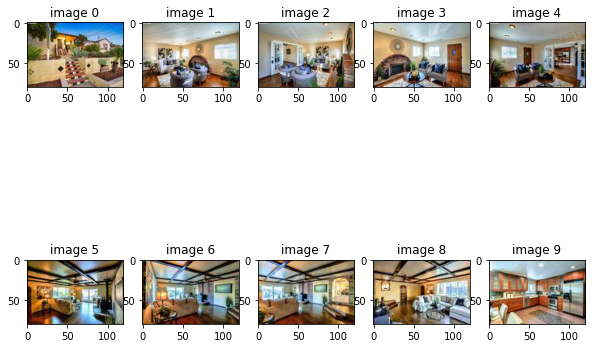

In [167]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10, 8))

row = col = 0
for i in np.arange(10):
    ax[row, col].imshow(image_pixels[i])
    ax[row, col].set_title('image {}'.format(i))
    col += 1
    if col > 4: 
        col = 0
        row += 1

In [150]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
                                featurewise_center=True,
                                featurewise_std_normalization=True,
                                
                            )

In [ ]:
import scipy.misc

# for i in range(pixels.shape[0]):
#     image = 
# scipy.misc.imsave('outfile.jpg', image_array)